# Comparing ModernBERT with series of Bert Models

This notebook compares ModernBert with several established BERT-based models, such as Google's BERT, ALBERT, and RoBERTa, using the [Uber10K dataset](https://llamahub.ai/l/llama_datasets/Uber%2010K%20Dataset%202021), which contains question-answer pairs. OpenAI embeddings are used to represent the questions and answers, allowing us to assess the performance of ModernBert embeddings against OpenAI’s. The comparison focuses on key tasks like question answering and semantic understanding, evaluating accuracy, efficiency, and overall performance.

**The goal is to highlight the strengths and weaknesses of ModernBert in comparison to these well-known models.**

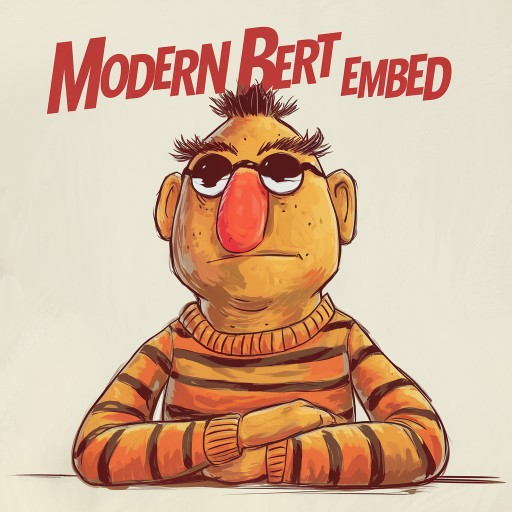

ModernBERT Embed is an embedding model trained from ModernBERT-base, bringing the new advances of ModernBERT to embeddings!

Trained on the Nomic Embed weakly-supervised and supervised datasets, modernbert-embed also supports Matryoshka Representation Learning dimensions of 256, reducing memory by 3x with minimal performance loss.

## Installations

We'll use Huggingface transformers for extracting embeddings for all the models. For this we'll install latest version fo transformer

In [ ]:
# install latest transformers
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ie06m4wt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ie06m4wt
  Resolved https://github.com/huggingface/transformers to commit 33cb1f7b615f59f3d18de1f13bddfcbfa6b863a5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.49.0.dev0-py3-none-any.whl size=10582079 sha256=bfb08d3dc51c5627b7065a3a328e793a6ee5a491f39ff6fc7726112a4525e9a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-xuu9ewv_/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


Install all the dependencies related to llama-index

In [ ]:
# install llama-index and related dependencies
!pip install lancedb llama-index llama-index-core llama-index-embeddings-huggingface llama-index-embeddings-openai llama-index-readers-file llama-index-readers-llama-parse llama-index-vector-stores-lancedb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.2/32.2 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.0/248.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.6 MB/s eta 0:00:00


## Dataset

For this comparison, we'll use [Uber 2021 10K Dataset](https://llamahub.ai/l/llama_datasets/Uber%2010K%20Dataset%202021)


**Description**: A labelled RAG dataset based on the Uber 2021 10K document, consisting of queries, reference answers, and reference contexts.

**Number Of Examples**: 822

In [ ]:
!pip install llama-index-cli -q
!llamaindex-cli download-llamadataset Uber10KDataset2021 --download-dir ./data

100% 1/1 [00:00<00:00,  1.66it/s]
Successfully downloaded Uber10KDataset2021 to ./data


## Comparitive Evaluation

In [ ]:
# import dependencies
import time
from tqdm import tqdm
import re
import unicodedata
import pandas as pd

from llama_index.core import SimpleDirectoryReader
from llama_index.core.llama_dataset import LabelledRagDataset
from llama_index.vector_stores.lancedb import LanceDBVectorStore
from llama_index.core import VectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.schema import TextNode, NodeRelationship, RelatedNodeInfo
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.settings import Settings

In [ ]:
# helper functions for evaluation

def normalize_text(text):
    """
        Normalize text by converting to lowercase, removing non-alphanumeric characters,
        and removing extra whitespace.
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def evaluate(
    docs,
    dataset,
    embed_model=None,
    top_k=5,
    verbose=False,
):
    """
        Evaluate a given embedding model on a given dataset.
    """
    vector_store = LanceDBVectorStore(uri=f"/tmp/lancedb_modernbert-{time.time()}")
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    service_context = Settings._embed_model=embed_model
    index = VectorStoreIndex.from_documents(
        docs,
        service_context=service_context,
        show_progress=True,
        storage_context=storage_context,
    )
    tbl = vector_store._connection.open_table(vector_store._table_name)
    tbl.create_fts_index("text", replace=True)

    eval_results = []
    ds = dataset.to_pandas()
    for idx in range(len(ds)):
        query = ds["query"][idx]
        reference_context = ds["reference_contexts"][idx]
        query_vector = embed_model.get_query_embedding(query)
        try:
            rs = tbl.search(query_vector).limit(top_k).to_pandas()
        except Exception as e:
            print(f"Error with query: {idx} {e}")
            continue

        retrieved_texts = rs["text"].tolist()[:top_k]
        expected_text = reference_context[0]

        # normalized retrieved texts
        retrieved_texts = [normalize_text(text) for text in retrieved_texts]
        expected_text = normalize_text(expected_text)

        is_hit = expected_text in retrieved_texts  # assume 1 relevant doc
        eval_result = {
            "is_hit": is_hit,
            "retrieved": retrieved_texts,
            "expected": expected_text,
            "query": query,
        }
        eval_results.append(eval_result)
        # print("Retrieved: ", retrieved_texts)
        # print("Expected: ", expected_text)

    return eval_results

In [ ]:
# loading dataset and question answers
rag_dataset = LabelledRagDataset.from_json("./data/rag_dataset.json")
documents = SimpleDirectoryReader(input_dir="./data/source_files").load_data()


# listed model to perform comparitive analysis for retrieval
embed_models = {
    "modern_bert": HuggingFaceEmbedding(model_name="nomic-ai/modernbert-embed-base"),
    "google_bert": HuggingFaceEmbedding(model_name="google-bert/bert-base-uncased"),
    "roberta": HuggingFaceEmbedding(model_name="deepset/roberta-base-squad2"),
    "albert": HuggingFaceEmbedding(model_name="albert/albert-base-v2"),
    "distilbert": HuggingFaceEmbedding(model_name="distilbert/distilbert-base-uncased"),
    "tinybert": HuggingFaceEmbedding(model_name="Intel/dynamic_tinybert"),

}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/445k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Intel/dynamic_tinybert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Invalid model-index. Not loading eval results into CardData.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.


In [ ]:
scores = {}

# storing scores for comparison
for embed_name, embed_model in embed_models.items():
    eval_results = evaluate(
        docs=documents,
        dataset=rag_dataset,
        embed_model=embed_model,
        top_k=20,
        verbose=False,
    )
    print(f"Embedder {embed_name}: ")
    score = pd.DataFrame(eval_results)["is_hit"].mean()
    print(score)
    scores[embed_name] = score

Parsing nodes:   0%|          | 0/307 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/395 [00:00<?, ?it/s]

Embedder modern_bert: 
0.2749391727493917


Parsing nodes:   0%|          | 0/307 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/395 [00:00<?, ?it/s]

Embedder google_bert: 
0.20924574209245742


Parsing nodes:   0%|          | 0/307 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/395 [00:00<?, ?it/s]

Embedder roberta: 
0.014598540145985401


Parsing nodes:   0%|          | 0/307 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/395 [00:00<?, ?it/s]

Embedder albert: 
0.16423357664233576


Parsing nodes:   0%|          | 0/307 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/395 [00:00<?, ?it/s]

Embedder distilbert: 
0.20802919708029197


Parsing nodes:   0%|          | 0/307 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/395 [00:00<?, ?it/s]

Embedder tinybert: 
0.012165450121654502


In [ ]:
scores

{'modern_bert': 0.2749391727493917,
 'google_bert': 0.20924574209245742,
 'roberta': 0.014598540145985401,
 'albert': 0.16423357664233576,
 'distilbert': 0.20802919708029197,
 'tinybert': 0.012165450121654502}

## Plotting Graph

Plotting evaluation scores to compare Modernbert with other models in bert series (Google's bert, Roberta, Albert, DistilBert, TinyBert) using QA dataset which is prepared using OpenAI embeddings.

<ipython-input-13-555835f472e3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Score", data=df, palette=palette)


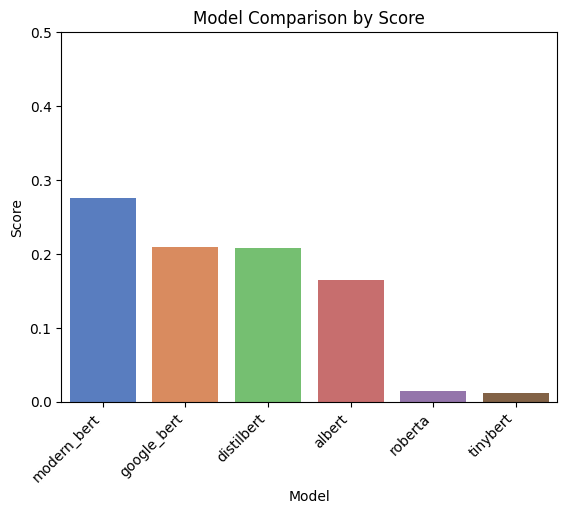

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
df = pd.DataFrame(list(scores.items()), columns=["Model", "Score"])

palette = sns.color_palette("muted", len(df))
sns.barplot(x="Model", y="Score", data=df, palette=palette)

plt.ylim(0, 0.5)

plt.xticks(rotation=45, ha='right')
plt.title("Model Comparison by Score")
plt.show()


### This graph clearly shows that ModernBert clearly outperforms its respective Bert series models. But this retrival comparison is with OpenAI embedding and on Uber-10K dataset.

Note: Results may vary on other datasets